In [1]:
# Clone the entire repo.
!git clone -l -s https://github.com/moheb432/principles-of-smile.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 6452, done.
remote: Counting objects: 100% (1673/1673), done.
remote: Compressing objects: 100% (1669/1669), done.
remote: Total 6452 (delta 4), reused 1662 (delta 4), pack-reused 4779
Receiving objects: 100% (6452/6452), 340.74 MiB | 19.44 MiB/s, done.
Resolving deltas: 100% (267/267), done.
Checking out files: 100% (6381/6381), done.
/content/cloned-repo
 add_augmented_to_csv.py		 mobile-net.ipynb
 all_teeth				 old
'biometrics_dataset - Sheet1.csv'	 README.md
 Copy_of_biometrics_task_model_1.ipynb	 resize_with_padding.py
 data_augmentation.py			 smile_dataset
 dataset_2_almid.xlsx			'teeth_not cropped'
 dataset_7_classes.csv			 Untitled.ipynb
 dataset_and_augmented.csv		 vgg.ipynb
 dataset.csv				 vgg_transfer_faces.ipynb
 dataset_split.ipynb			 vgg_transfer_padded_faces.ipynb
 Dlib-68-face-landmark.png		 vgg_transfer_padded_teeth.ipynb
 faces					 vgg_transfer_teeth.ipynb
 faces+teeth				 weight_converting.ipynb
 images_pre

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.models import Sequential
from keras.layers.convolutional import ZeroPadding2D
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

## 1- load Images dataset

In [4]:
def append_ext(fn):
    return str(fn)+".jpg"

#loading dataset labels from csv 
df = pd.read_csv("dataset_and_augmented.csv")

# df["img"] = df["img"].apply(append_ext)

df = df.replace(np.nan, 0)

# labels names in csv
classes = ['9-gummy', '16-Incisal Embrasure', '4-color', '41-Central Incisor W/H Ratio', '18-black triangle', '8-gaps', '52-Crooked']



In [5]:
#shuffle dataframe before splitting 
df=df.sample(frac=1).reset_index(drop=True)

In [6]:

# load images in dataframe from saving directory 
# pationing dataset to 80:10:10 , train:valid:test sets
train_data_generation = ImageDataGenerator( samplewise_center=True,rescale = 2/255.)


training_set = train_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="./all_teeth/teeth_padded/train",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode="raw",seed=0)


valid_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 2/255.)

valid_set = valid_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="./all_teeth/teeth_padded/valid",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode="raw",seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(samplewise_center=True,rescale = 2/255.)

test_set = test_data_generation.flow_from_dataframe(dataframe=df[:],
                                                         directory="./all_teeth/teeth_padded/test",
                                                         x_col="img",
                                                         y_col=classes,
                                                         target_size=(224, 224),
                                                         batch_size=1,
                                                         class_mode="raw",seed=0, shuffle = False)


Found 1821 validated image filenames.
Found 116 validated image filenames.
Found 488 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 642 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2347 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1975 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [7]:
# Store the data in X_test, y_test variables by iterating over the batches
batch_size =1
X_test, y_test = next(test_set)
for i in range(int(len(test_set)/batch_size)-1): #1st batch is already fetched before the for loop.
    img , label = next(test_set)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(X_test.shape, y_test.shape)

(488, 224, 224, 3) (488, 7)


### Example image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image labels:
['16-Incisal Embrasure', '41-Central Incisor W/H Ratio']
-0.22655274


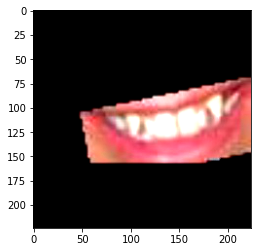

In [8]:
img =next(training_set)
#print(classes)

l=[]
for i, x in enumerate(classes):
    if img[1][0][i]==1 :
        l.append(x)

print("image labels:")
print(l)

img=img[0][0]  #first image
#print(img.shape)
# print(img)
print(np.amin(img.flatten()))
plt.imshow(img)
training_set.reset()

## 2- Model : VGG-16 with pre-trained weights of face recognition task

In [25]:
model = Sequential()
model.add(keras.Input(shape=(224,224,3)))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_1"))
model.add(Conv2D(64, (3, 3), activation='relu',name="conv1_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_1"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv2_2"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_1"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_2"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv3_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))
 
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv4_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_1"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_2"))
model.add(Conv2D(512, (3, 3), activation='relu',name="conv5_3"))
model.add(MaxPool2D((2,2), strides=(2,2)))

model.load_weights('/content/drive/MyDrive/vgg_face_weights.h5', by_name=True,skip_mismatch=True)

#freezing layers
for layer in model.layers:
    layer.trainable = False

model.get_layer("conv3_1").trainable =True
#model.get_layer("conv3_3").trainable =True
#model.get_layer("conv4_1").trainable =True
model.get_layer("conv4_1").trainable =True
model.get_layer("conv4_2").trainable =True
model.get_layer("conv5_3").trainable =True
model.get_layer("conv5_2").trainable =True
model.get_layer("conv5_1").trainable =True


#adding output layers
model.add(Flatten())

# model.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.025)))
model.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.02)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Dropout(0.5))

# model.add( Dense(64,use_bias=False, kernel_regularizer=keras.regularizers.L2(0.025)))
model.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.015)))
model.add(BatchNormalization())
model.add(Activation("relu"))

# model.add(Dropout(0.5))

# model.add( Dense(16, use_bias=False,kernel_regularizer=keras.regularizers.L2(0.025)))
# model.add(BatchNormalization())
# model.add(Activation("relu"))

model.add(Dense(7, activation='sigmoid'))
# summarize

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 222, 222, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2_1 (Conv2D)            (None, 108, 108, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [26]:
initial_learning_rate = 0.00025
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

#model combile
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),loss = 'BinaryCrossentropy',metrics=['binary_accuracy'])

#fit model
history=model.fit(x=training_set, validation_data=valid_set, epochs=60 , shuffle =True)


Epoch 1/60
114/114 [==============================] - 23s 189ms/step - loss: 2.6379 - binary_accuracy: 0.5599 - val_loss: 2.1673 - val_binary_accuracy: 0.6466
Epoch 2/60
114/114 [==============================] - 21s 186ms/step - loss: 1.6762 - binary_accuracy: 0.6246 - val_loss: 1.4879 - val_binary_accuracy: 0.5727
Epoch 3/60
114/114 [==============================] - 21s 186ms/step - loss: 1.1898 - binary_accuracy: 0.6833 - val_loss: 1.1033 - val_binary_accuracy: 0.6810
Epoch 4/60
114/114 [==============================] - 21s 187ms/step - loss: 0.9374 - binary_accuracy: 0.7189 - val_loss: 0.9193 - val_binary_accuracy: 0.6909
Epoch 5/60
114/114 [==============================] - 21s 187ms/step - loss: 0.7914 - binary_accuracy: 0.7574 - val_loss: 0.7929 - val_binary_accuracy: 0.7377
Epoch 6/60
114/114 [==============================] - 21s 187ms/step - loss: 0.6977 - binary_accuracy: 0.7746 - val_loss: 0.7161 - val_binary_accuracy: 0.7512
Epoch 7/60
114/114 [==========================

## Plotting Diagnostic curves

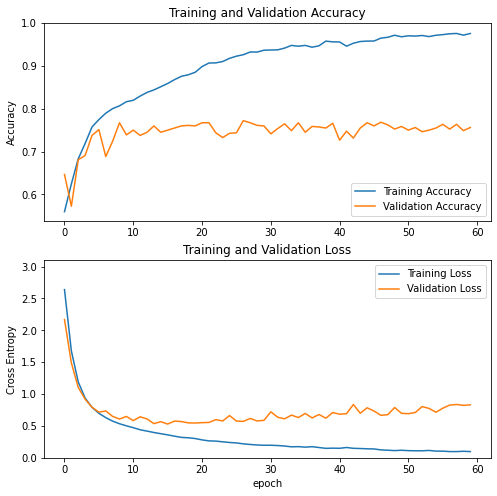

In [27]:
#plotting training and validation accuracy vs epochs
#plotting training and validation loss vs epochs
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
predictions= model.predict(test_set)
y_pred=[]
for pred in predictions:
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    y_pred.append(pred)

y_pred = np.array(y_pred)
pd.DataFrame(predictions)

,0,1,2,3,4,5,6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
483,0.0,1.0,1.0,1.0,0.0,0.0,0.0
484,1.0,1.0,0.0,1.0,0.0,0.0,0.0
485,1.0,1.0,0.0,0.0,0.0,0.0,0.0
486,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [29]:
from sklearn.metrics import classification_report

label_names = classes

print(classification_report(y_test, y_pred,target_names=label_names))

                              precision    recall  f1-score   support

                     9-gummy       0.83      0.62      0.71       164
        16-Incisal Embrasure       0.71      0.74      0.72       260
                     4-color       0.88      0.74      0.80       328
41-Central Incisor W/H Ratio       0.49      0.49      0.49       176
           18-black triangle       0.57      0.37      0.45        68
                      8-gaps       0.82      0.58      0.68        88
                  52-Crooked       0.50      0.15      0.23       124

                   micro avg       0.73      0.59      0.65      1208
                   macro avg       0.69      0.53      0.58      1208
                weighted avg       0.72      0.59      0.64      1208
                 samples avg       0.53      0.48      0.47      1208



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


true labels : 9-gummy, 16-Incisal Embrasure, 4-color
predicted labels : 9-gummy, 16-Incisal Embrasure, 4-color


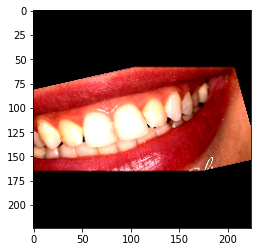

In [30]:
n=120
# output sample
true_labels=[]
pred_labels = []

for y ,z  in zip(y_test,y_pred):
    true =[]
    pred =[]
    for i, x in enumerate(classes):
        if y[i]==1 :
            true.append(x)
            
        if z[i]==1 :
            pred.append(x)
    true_labels.append(", ".join(true))
    pred_labels.append(", ".join(pred))
        
#print(test_set.index_array)
print("true labels : "+true_labels[n])
print("predicted labels : "+pred_labels[n])

plt.imshow(X_test[n])

#['gummy', 'golden_proportion ', 'gap', 'crowding', 'incisal embrassure ', 'color', 'Central line', 'Crooked', 'Central Incisor W/H Ratio', 'Black triangle', 'perfect']

In [31]:
model.save("vgg_teeth.h5")